In [1]:
import generator
import model
import os
import matplotlib.pyplot as plt
import math


### Loss functions and Embedding size

In [2]:
import pickle
import torch
import fastbook
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.losses import *
import torch.nn as nn


def get_small_emb_sz(dls_df, n_bits=None):
    emb = get_emb_sz(dls_df)   # corresponds to number of nodes in each column
    print("recommended emb size", emb)
    emb = max(emb,key=lambda x:x[0])
    if n_bits == None:
        n_bits = emb[1]
    print("\tusing emb size:", (emb[0], n_bits))
    return [(emb[0], n_bits)]


def MRELoss(inp, targ) -> Tensor:
    inp = torch.flatten(inp).float()
    targ = torch.flatten(targ).float()
    nom = torch.nn.functional.l1_loss(inp, targ)
    noo = torch.Tensor([0]).repeat(targ.size(0)).to(device)
    denom = torch.nn.functional.l1_loss(noo, targ)
    loss = (nom / denom).mean()
    return loss


def CombineLoss(inp, targ) -> Tensor:
    mse_loss = MSELossFlat()
    loss_1 = mse_loss(inp, targ)

    loss_2 = MRELoss(inp, targ)

    return alpha * loss_1 + (1 - alpha) * loss_2

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# learn.recorder()from fastai2.imports import *
# from fastai2.torch_core import *
# from fastai2.learner import *
# call as: learn.recorder.plot_metrics()
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()
    

In [4]:
def create_model(dataset, loss_function, n_bits, valid_pct, savepath):
    if (not os.path.exists(savepath)):
        os.makedirs(savepath)

    data = np.array(dataset)
    df = pd.DataFrame(data, columns=['src', 'dst', 'label'])
    dls_df = CollabDataLoaders.from_df(df, bs=64, valid_pct=valid_pct)
    
    embs_sz = get_small_emb_sz(dls_df, n_bits)
    # multiply number of nodes by 2. max distance cannot be larger than this
    # this represents the max width of an individual graph
    max_value = df.label.max() * 2
    print("max node is", (df.src.max(), df.dst.max()), "gotten by max label:", df.label.max(), "* embedding matrix size: ", embs_sz[0][0])
    trainer = model.CollabNN(*embs_sz, y_range=(0, max_value))

    learn = Learner(dls_df, trainer, loss_func=loss_function, path=savepath, metrics=[mse, mae, MRELoss])
    
    return learn, df


def train_model(dataset, num_epochs, loss_function, valid_pct, n_bits=None, savepath="save/default/"):

    learn, df = create_model(dataset, loss_function, n_bits, valid_pct, savepath)

#     SaveModelCallback(with_opt=True)
    learn.remove_cb(ProgressCallback) #remove (uncomment) progresscallback if running from terminal

    learn.fit_one_cycle(n_epoch=num_epochs, lr_max=5e-3, wd=0.01)
    #, cbs=[EarlyStoppingCallback(monitor='train_loss', min_delta=1e-6, patience=100)])  #ShowGraphCallback(), 
    
    learn.save('model')
    allnodes = set(df.src).union(set(df.dst))
    embs = learn.model.save_embeddings(Tensor(list(allnodes)).to(device).int())

    with open(savepath + "embeddings.pkl", "wb") as outfile:
        pickle.dump(embs, outfile)
    
    return learn

### get the datasets

In [5]:
def get_cycles_dataset(lg_N):
    cy_datapath =  'save/data/cycle/log_' + str(lg_N) + '_data'

    if os.path.isfile(cy_datapath):
        cycles_dataset = generator.load_dataset_from_file(cy_datapath)
        print("similar data gotten before... retrieved data")
    else:
        cycles_dataset = generator.generate_cycles_dataset(lg_N)
        generator.save_dataset_to_file(cycles_dataset, cy_datapath)
    cycles_dataset = np.array(cycles_dataset)
#     np.random.shuffle(cycles_dataset)
#     cycles_trainset, cycles_testset = cycles_dataset[:int(train_pct*len(cycles_dataset)),:], cycles_dataset[int(train_pct*len(cycles_dataset)):,:]
    
    return cycles_dataset

In [6]:
def get_graphs_dataset(real_graph_paths=None):
    if real_graph_paths == None:
        real_graph_paths = [
                            "/jumbo/lisp/ike/code/DistanceLabelling/datasets/ENZYMES_g1/ENZYMES_g1.edges",
                            "/jumbo/lisp/ike/code/DistanceLabelling/datasets/ENZYMES_g1/ENZYMES_g1.edges", 
                           "/jumbo/lisp/ike/code/DistanceLabelling/datasets/ENZYMES_g118/ENZYMES_g118.edges"
                           ]
    gr_datapath =  'save/data/graph/ngraphs_' + str(len(real_graph_paths)) + '_data'

    if os.path.isfile(gr_datapath):
        graphs_dataset = generator.load_dataset_from_file(gr_datapath)
        print("similar data gotten before... retrieved data")
    else:
        graphs_dataset = generator.generate_real_graphs_dataset(real_graph_paths)
        generator.save_dataset_to_file(graphs_dataset, gr_datapath)
    graphs_dataset = np.array(graphs_dataset)
#     np.random.shuffle(graphs_dataset)
#     graphs_trainset, graphs_testset = graphs_dataset[:int(train_pct*len(graphs_dataset)),:], graphs_dataset[int(train_pct*len(graphs_dataset)):,:]
    
    return graphs_dataset

In [7]:
def get_trees_dataset(lg_N):
    tr_datapath =  'save/data/tree/log_' + str(lg_N) + '_data'

    if os.path.isfile(tr_datapath):
        trees_dataset = generator.load_dataset_from_file(tr_datapath)
        print("similar data gotten before... retrieved data")
    else:
        trees_dataset = generator.generate_trees_dataset(2**lg_N)
        generator.save_dataset_to_file(trees_dataset, tr_datapath)

    trees_dataset = np.array(trees_dataset)
#     np.random.shuffle(trees_dataset)
#     trees_trainset, trees_testset = trees_dataset[:int(train_pct*len(trees_dataset)),:], trees_dataset[int(train_pct*len(trees_dataset)):,:]

    return trees_dataset

In [8]:
def get_cycle_model(alpha, num_epochs, n_bits, loss_function, lg_N, train_pct):
    # create and train on cycles
    split = train_pct*100
    savepath = 'save/cycle/'+str(n_bits) + 'bits/split_' + str(
        split) + '_' + str(alpha) + '_' + str(lg_N) + '_' + str(num_epochs) + '/'

    saved = savepath+"models/model.pth" 
    trainset = get_cycles_dataset(lg_N)
    if os.path.isfile(saved):
        cycle_model, df = create_model(trainset, loss_function, n_bits, 1-train_pct, savepath)
        cycle_model.load('model')
        print("exact model trained before... retrieved model")
    else:
        cycle_model = train_model(trainset, num_epochs, loss_function, 1-train_pct, n_bits=n_bits, savepath=savepath)
        cycle_model.recorder.plot_metrics()
    return cycle_model

In [17]:
def get_graph_model(alpha, num_epochs, n_bits, loss_function, train_pct):
    split = train_pct*100
    # create and train on real graphs
    savepath = 'save/graph/' +str(n_bits) + 'bits/split_' + str(split) + '_' + str(alpha) + '_' + str(num_epochs) + '/'
    
    saved = savepath+"models/model.pth"
    trainset = get_graphs_dataset()
    if os.path.isfile(saved):
        graph_model, df = create_model(trainset, loss_function, n_bits, 1-train_pct, savepath)
        graph_model.load('model')
        print("exact model trained before... retrieved model")
    else:
        graph_model = train_model(trainset, num_epochs, loss_function, 1-train_pct, n_bits=n_bits, savepath=savepath)
        graph_model.recorder.plot_metrics()
    return graph_model

In [10]:
def get_tree_model(alpha, num_epochs, n_bits, loss_function, lg_N, train_pct):
    # create and train on trees
    split = train_pct*100
    savepath = 'save/tree/'+str(n_bits) + 'bits/split_' + str(
        split) + '_' + str(alpha) + '_' + str(lg_N) + '_' + str(num_epochs) + '/'
    
    saved = savepath+"models/model.pth"
    trainset = get_trees_dataset(lg_N)
    if os.path.isfile(saved):
        tree_model, df = create_model(trainset, loss_function, n_bits, 1-train_pct, savepath)
        tree_model.load('model')
        print("exact model trained before... retrieved model")
    else:
        tree_model = train_model(trainset, num_epochs, loss_function, 1-train_pct, n_bits=n_bits, savepath=savepath)
#         print(tree_model.model.node_to_emb)
        tree_model.recorder.plot_metrics()
        
    return tree_model

In [18]:
def plot_bits_to_loss(max_bits, trainloss, model_type, alpha, num_epochs, eval_loss, lossname, train_pct, lg_N=4):
    losses = []
    for n_bits in range(1, max_bits):
      print("using", n_bits, "bits")
      if model_type.lower() == 'cycle':
        lodel = get_cycle_model(alpha, num_epochs, n_bits, trainloss, lg_N, train_pct)
        max_bits = int(math.log2(lodel.num_nodes)+2) if n_bits == 1 else max_bits
      elif model_type.lower() == 'tree':
        lodel = get_tree_model(alpha, num_epochs, n_bits, trainloss, lg_N, train_pct)
        max_bits = int(math.log2(lodel.num_nodes)+2) if n_bits == 1 else max_bits
      elif model_type.lower() == 'graph':
        lodel = get_graph_model(alpha, num_epochs, n_bits, trainloss, train_pct)
        max_bits = int(2*math.log2(lodel.num_nodes)) if n_bits == 1 else max_bits
      else:
        print("incorrect input")
        return
      
      print("max bits is: ", max_bits)
      print("num bits used is: ", lodel.n_bits)
      validset = Tensor(np.array(lodel.dls.valid.dataset.items.iloc[:,:2], dtype=np.int32)).to(device).to(int)
      y_targ = Tensor(np.array(lodel.dls.valid.dataset.items.iloc[:,2], dtype=np.int32)).to(device).to(int)
      preds = lodel.model(validset)
      loss = eval_loss(preds, y_targ)
      print("loss is: ", loss)
      losses.append(float(loss))

    plt.plot(range(1, len(losses)+1), losses)
    savepath = 'save/plot/'+lossname+'/' + model_type + '_' + str(alpha) + '_' + str(max_bits) + '.png'
    os.makedirs(os.path.dirname(savepath), exist_ok=True)
    
    plt.title(lossname + ' loss for ' + model_type + ' model')
    plt.savefig(savepath)
    plt.show()

In [12]:
# shared hyperparams
num_epochs = 350
alpha = 0.1
loss_function = CombineLoss
# n_bits = 4
lg_N = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_pct = 0.75
eval_loss = MRELoss


# import osCombineLoss
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


using 1 bits
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 1)
max node is (492, 492) gotten by max label: 18 * embedding matrix size:  494
[0, 11.648360252380371, 7.1763224601745605, 58.36886215209961, 6.722766399383545, 1.4882608652114868, '00:01']
[1, 3.3329074382781982, 1.6316229104995728, 10.905160903930664, 2.718627452850342, 0.6012302041053772, '00:01']
[2, 1.4357730150222778, 1.2733672857284546, 8.199843406677246, 2.2867836952209473, 0.5037584900856018, '00:00']
[3, 1.241036057472229, 1.2745988368988037, 8.230045318603516, 2.2785894870758057, 0.5017713904380798, '00:00']
[4, 1.227630615234375, 1.2788830995559692, 8.228464126586914, 2.299365282058716, 0.5067076086997986, '00:00']
[5, 1.2412092685699463, 1.2930785417556763, 8.303980827331543, 2.331993818283081, 0.5140895247459412, '00:00']
[6, 1.2408835887908936, 1.277660846710205, 8.268465995788574, 2.274874687194824, 0.5009048581123352, '00:00']
[7, 1.2219260931015015, 1.3079874515533447, 8.40556812286377, 2

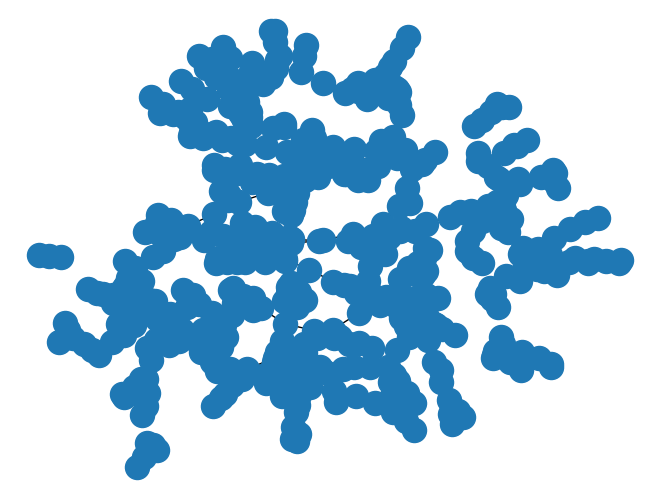

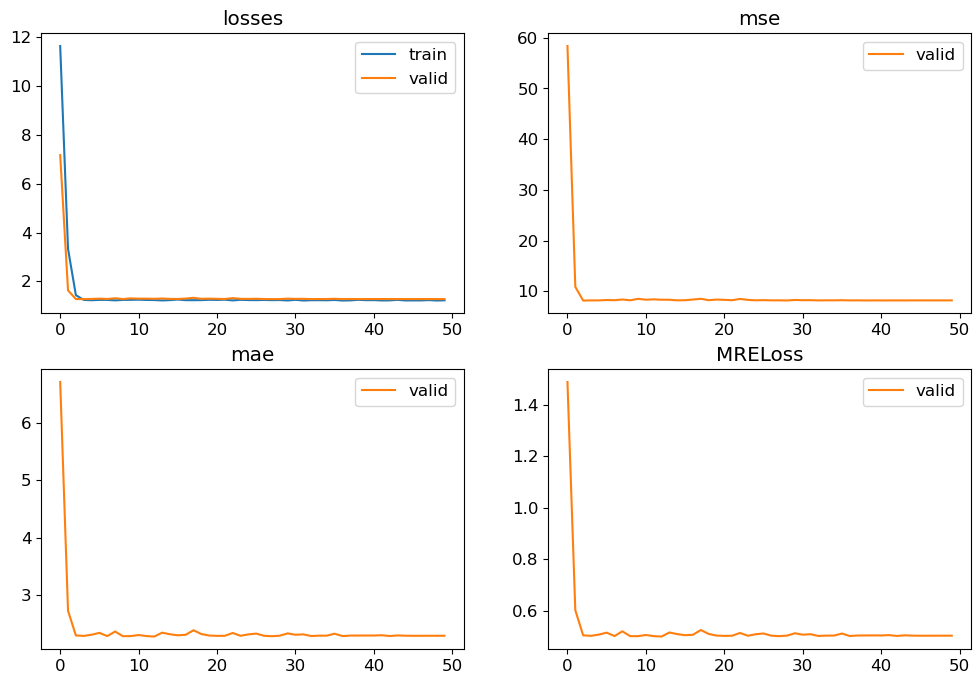

max bits is:  8
num bits used is:  1
loss is:  tensor(0.5015, device='cuda:0', grad_fn=<MeanBackward0>)
using 2 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 2)
max node is (492, 492) gotten by max label: 18 * embedding matrix size:  494
[0, 11.437487602233887, 6.930352687835693, 55.61791229248047, 6.890730857849121, 1.5206234455108643, '00:00']
[1, 3.2408926486968994, 1.5613728761672974, 10.292203903198242, 2.687957763671875, 0.5912805199623108, '00:00']
[2, 1.419942855834961, 1.2327234745025635, 7.9010910987854, 2.2444345951080322, 0.4917939007282257, '00:00']
[3, 1.226790428161621, 1.2289849519729614, 7.8624396324157715, 2.245053768157959, 0.49193447828292847, '00:00']
[4, 1.2299377918243408, 1.2316780090332031, 7.8879714012146, 2.2457735538482666, 0.4920899271965027, '00:00']
[5, 1.230000376701355, 1.2349791526794434, 7.889525890350342, 2.26115345954895, 0.4955851137638092, '00:00']
[6, 1.2536205053329468, 1.242

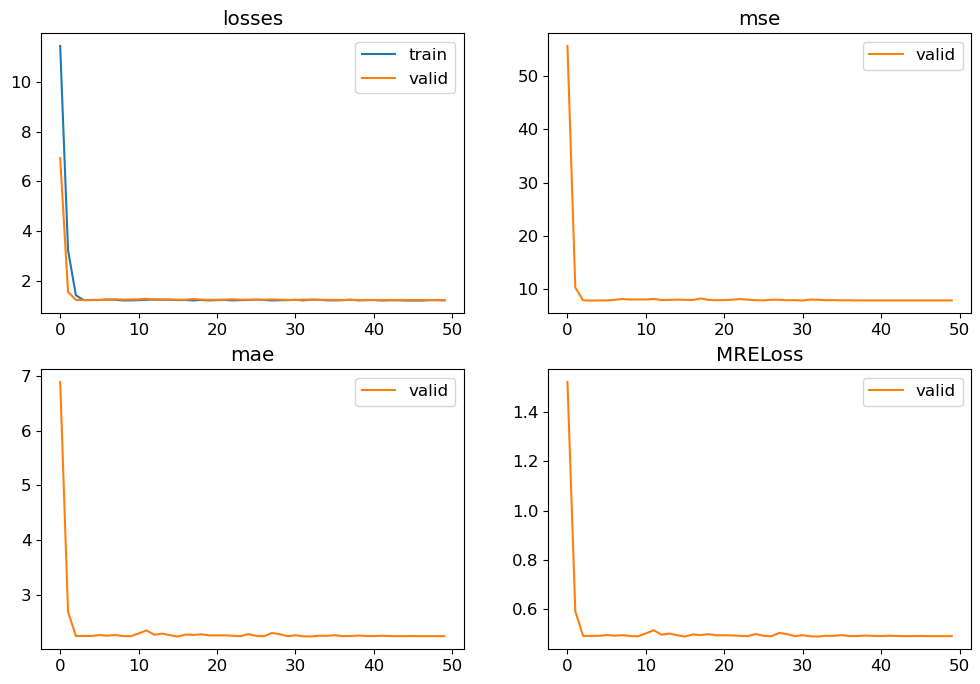

max bits is:  8
num bits used is:  2
loss is:  tensor(0.4906, device='cuda:0', grad_fn=<MeanBackward0>)
using 3 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 3)
max node is (492, 492) gotten by max label: 18 * embedding matrix size:  494
[0, 12.152091979980469, 7.713989734649658, 62.579307556152344, 7.263233661651611, 1.6178414821624756, '00:00']
[1, 3.5552940368652344, 1.6846938133239746, 11.226922988891602, 2.803100824356079, 0.6244460940361023, '00:00']
[2, 1.5115077495574951, 1.2670230865478516, 8.13463306427002, 2.2694647312164307, 0.5039554238319397, '00:00']
[3, 1.2757859230041504, 1.2426975965499878, 7.902509689331055, 2.2626500129699707, 0.5027185082435608, '00:00']
[4, 1.2539695501327515, 1.2332344055175781, 7.8777594566345215, 2.2299654483795166, 0.49495384097099304, '00:00']
[5, 1.242018699645996, 1.2172857522964478, 7.721879482269287, 2.226776123046875, 0.49455299973487854, '00:00']
[6, 1.24924004077911

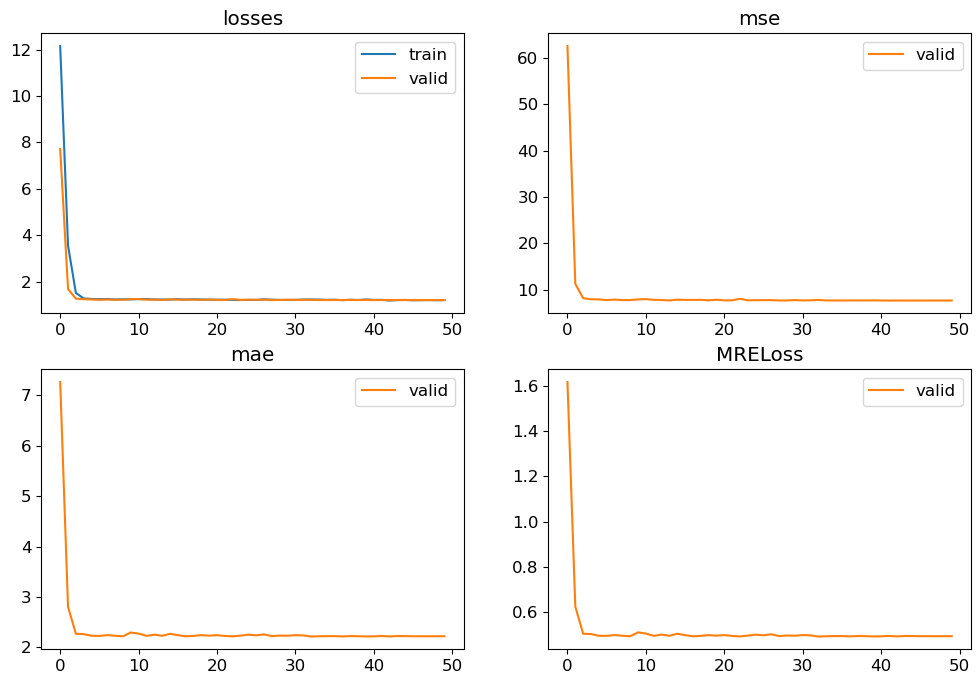

max bits is:  8
num bits used is:  3
loss is:  tensor(0.4912, device='cuda:0', grad_fn=<MeanBackward0>)
using 4 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 4)
max node is (492, 492) gotten by max label: 18 * embedding matrix size:  494
[0, 11.753997802734375, 7.961324691772461, 64.876953125, 7.372841835021973, 1.6373642683029175, '00:00']
[1, 3.823821544647217, 1.9111403226852417, 13.097627639770508, 3.015272617340088, 0.6681973934173584, '00:00']
[2, 1.518958330154419, 1.2702150344848633, 8.184935569763184, 2.274989128112793, 0.5019127130508423, '00:00']
[3, 1.2518583536148071, 1.2549548149108887, 8.02733039855957, 2.275665283203125, 0.5024687647819519, '00:00']
[4, 1.2109088897705078, 1.2463734149932861, 7.9652910232543945, 2.2646541595458984, 0.4998267590999603, '00:00']
[5, 1.2142306566238403, 1.2578561305999756, 8.05441665649414, 2.2777512073516846, 0.5026828646659851, '00:01']
[6, 1.2439213991165161, 1.24849

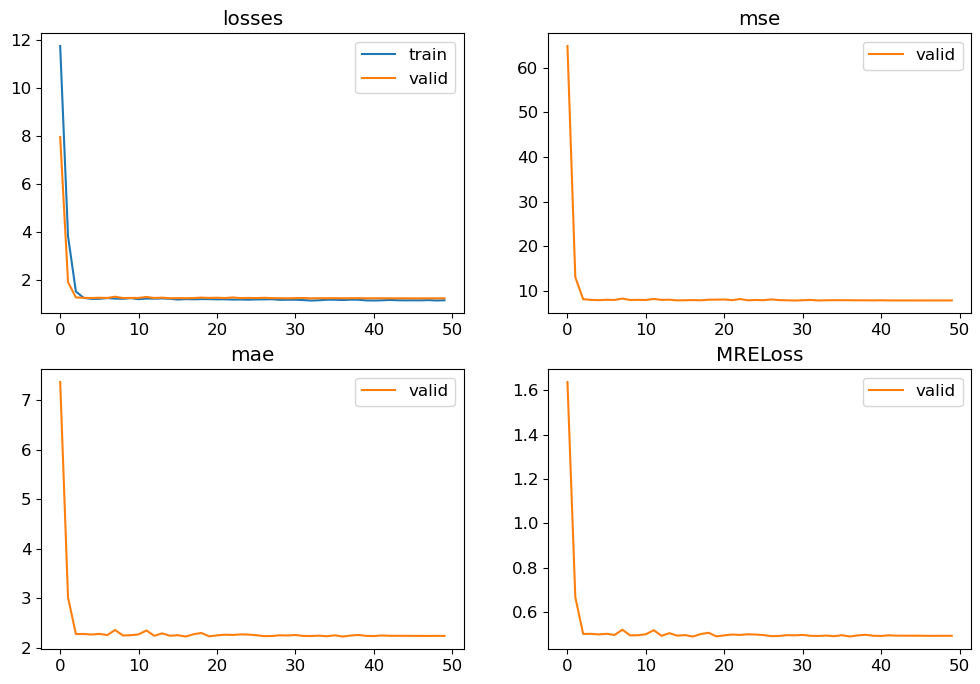

max bits is:  8
num bits used is:  4
loss is:  tensor(0.4919, device='cuda:0', grad_fn=<MeanBackward0>)
using 5 bits
similar data gotten before... retrieved data
recommended emb size [(493, 52), (494, 52)]
	using emb size: (494, 5)
max node is (492, 492) gotten by max label: 18 * embedding matrix size:  494
[0, 8.0986967086792, 4.7049784660339355, 36.539268493652344, 5.379298686981201, 1.1678358316421509, '00:00']
[1, 2.4806525707244873, 1.4370185136795044, 9.470767974853516, 2.5210185050964355, 0.544379711151123, '00:00']
[2, 1.3775542974472046, 1.316677451133728, 8.64609146118164, 2.332801580429077, 0.5022982954978943, '00:00']
[3, 1.238206148147583, 1.299853801727295, 8.507083892822266, 2.317866325378418, 0.49905040860176086, '00:00']
[4, 1.228927493095398, 1.2838151454925537, 8.375481605529785, 2.3031842708587646, 0.4958520531654358, '00:01']
[5, 1.2315605878829956, 1.288241982460022, 8.423450469970703, 2.3019940853118896, 0.4954410493373871, '00:00']
[6, 1.2302699089050293, 1.3064

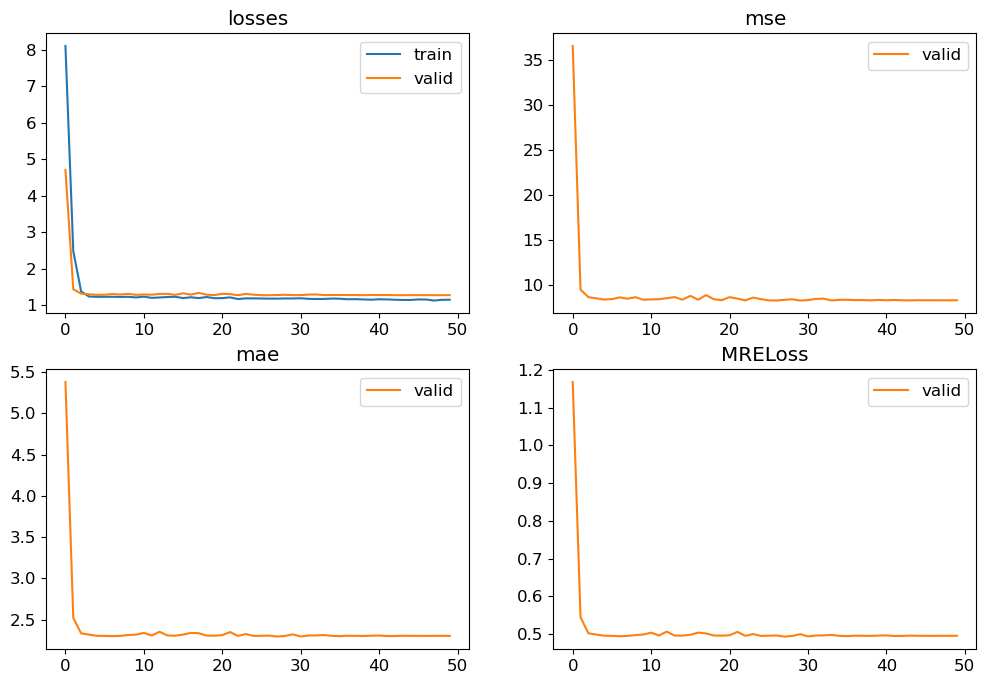

max bits is:  8
num bits used is:  5
loss is:  tensor(0.4950, device='cuda:0', grad_fn=<MeanBackward0>)
using 6 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 6)
max node is (492, 492) gotten by max label: 18 * embedding matrix size:  494
[0, 15.452160835266113, 10.20600700378418, 84.93220520019531, 8.616297721862793, 1.903098702430725, '00:01']
[1, 4.755978584289551, 2.105928421020508, 14.690949440002441, 3.2067506313323975, 0.7075925469398499, '00:00']
[2, 1.6621583700180054, 1.2843798398971558, 8.32720947265625, 2.2870421409606934, 0.501843273639679, '00:01']
[3, 1.284464716911316, 1.2581229209899902, 8.145963668823242, 2.24642014503479, 0.4928072690963745, '00:00']
[4, 1.2117968797683716, 1.2402297258377075, 7.971364498138428, 2.243102788925171, 0.49232572317123413, '00:00']
[5, 1.214884877204895, 1.2419188022613525, 8.000415802001953, 2.237351655960083, 0.4909747242927551, '00:00']
[6, 1.2193161249160767, 1.2618

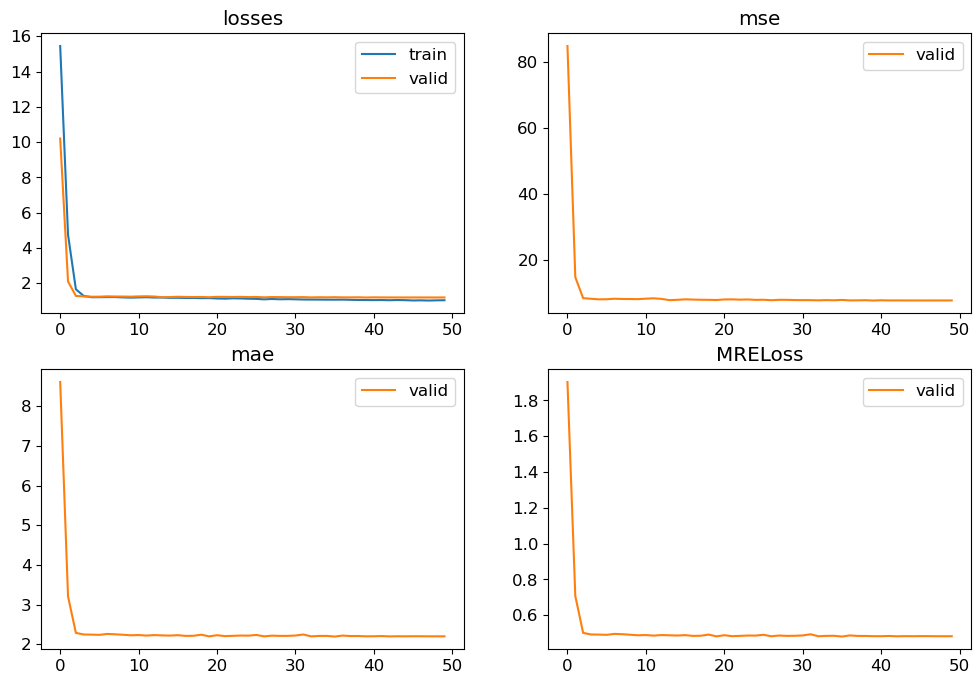

max bits is:  8
num bits used is:  6
loss is:  tensor(0.4815, device='cuda:0', grad_fn=<MeanBackward0>)
using 7 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 7)
max node is (492, 492) gotten by max label: 18 * embedding matrix size:  494
[0, 9.842547416687012, 6.0784149169921875, 48.06242370605469, 6.3465657234191895, 1.413525104522705, '00:01']
[1, 2.9997732639312744, 1.5291187763214111, 10.040611267089844, 2.6244795322418213, 0.5833973288536072, '00:01']
[2, 1.4567720890045166, 1.2521495819091797, 7.99805212020874, 2.268144130706787, 0.5026050209999084, '00:00']
[3, 1.304248571395874, 1.2355351448059082, 7.845703125, 2.261078357696533, 0.5010722279548645, '00:00']
[4, 1.218819499015808, 1.209693193435669, 7.6775431632995605, 2.216960906982422, 0.4910432994365692, '00:01']
[5, 1.2024245262145996, 1.2111942768096924, 7.685615062713623, 2.2195136547088623, 0.4918140172958374, '00:01']
[6, 1.2285079956054688, 1.215440

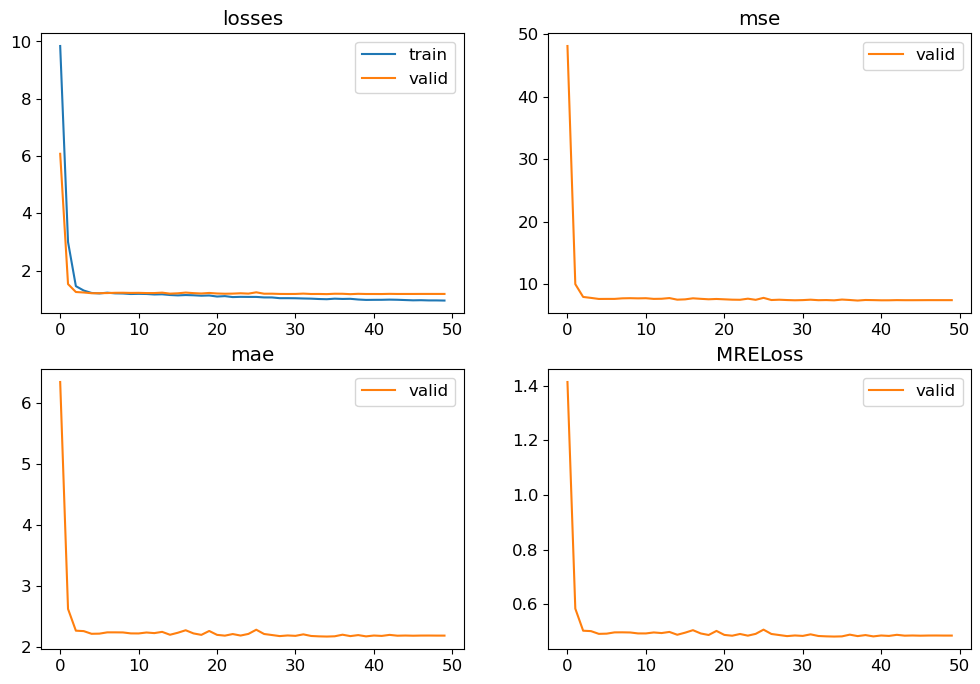

max bits is:  8
num bits used is:  7
loss is:  tensor(0.4835, device='cuda:0', grad_fn=<MeanBackward0>)
using 8 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 8)
max node is (492, 492) gotten by max label: 18 * embedding matrix size:  494
[0, 10.122745513916016, 5.8142876625061035, 46.08940887451172, 6.124974250793457, 1.3392733335494995, '00:02']
[1, 2.9624788761138916, 1.4996508359909058, 9.92127513885498, 2.5868117809295654, 0.5639147162437439, '00:01']
[2, 1.4384708404541016, 1.280470609664917, 8.317675590515137, 2.2970118522644043, 0.4985591173171997, '00:01']
[3, 1.2543418407440186, 1.24970543384552, 8.045367240905762, 2.2774977684020996, 0.49463194608688354, '00:02']
[4, 1.2202774286270142, 1.223649024963379, 7.85357666015625, 2.2426576614379883, 0.48699063062667847, '00:02']
[5, 1.192778468132019, 1.209883213043213, 7.747624397277832, 2.2277638912200928, 0.483467161655426, '00:02']
[6, 1.1987031698226929, 1.2

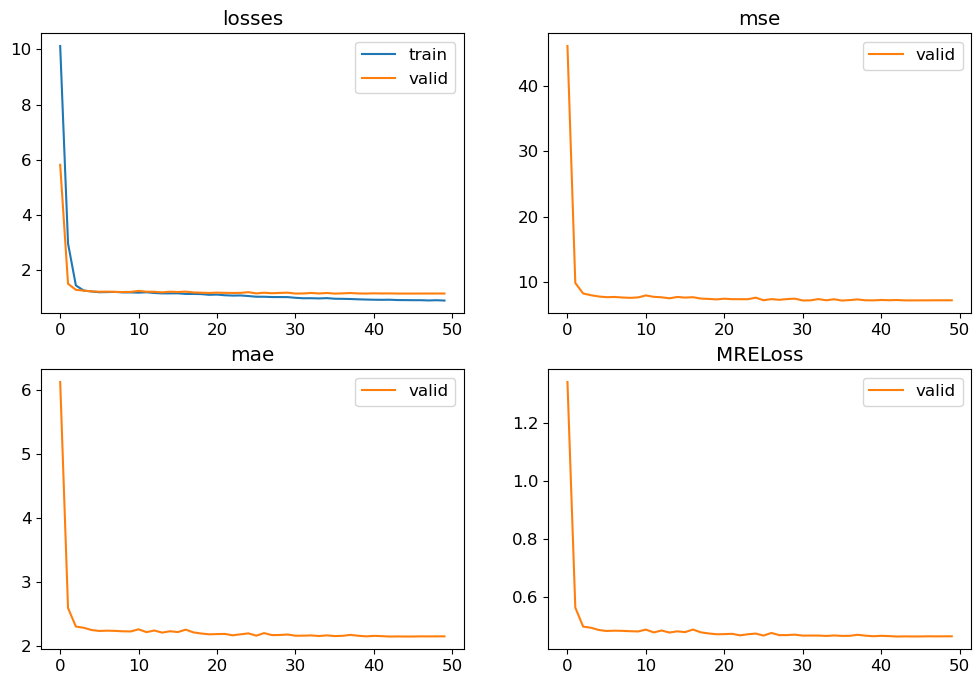

max bits is:  8
num bits used is:  8
loss is:  tensor(0.4634, device='cuda:0', grad_fn=<MeanBackward0>)
using 9 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 9)
max node is (492, 492) gotten by max label: 18 * embedding matrix size:  494
[0, 10.83566951751709, 6.6824116706848145, 53.6958122253418, 6.606533050537109, 1.4586998224258423, '00:02']
[1, 3.2509262561798096, 1.6526914834976196, 11.129348754882812, 2.723936080932617, 0.5997297763824463, '00:02']
[2, 1.4784201383590698, 1.3028491735458374, 8.47075080871582, 2.312391519546509, 0.5064155459403992, '00:02']
[3, 1.2609069347381592, 1.2654260396957397, 8.187216758728027, 2.267855167388916, 0.49633821845054626, '00:02']
[4, 1.235272765159607, 1.2356644868850708, 7.917416095733643, 2.2511236667633057, 0.49324747920036316, '00:02']
[5, 1.16567862033844, 1.2115988731384277, 7.768280029296875, 2.208317518234253, 0.4830787181854248, '00:01']
[6, 1.1745954751968384, 1.2

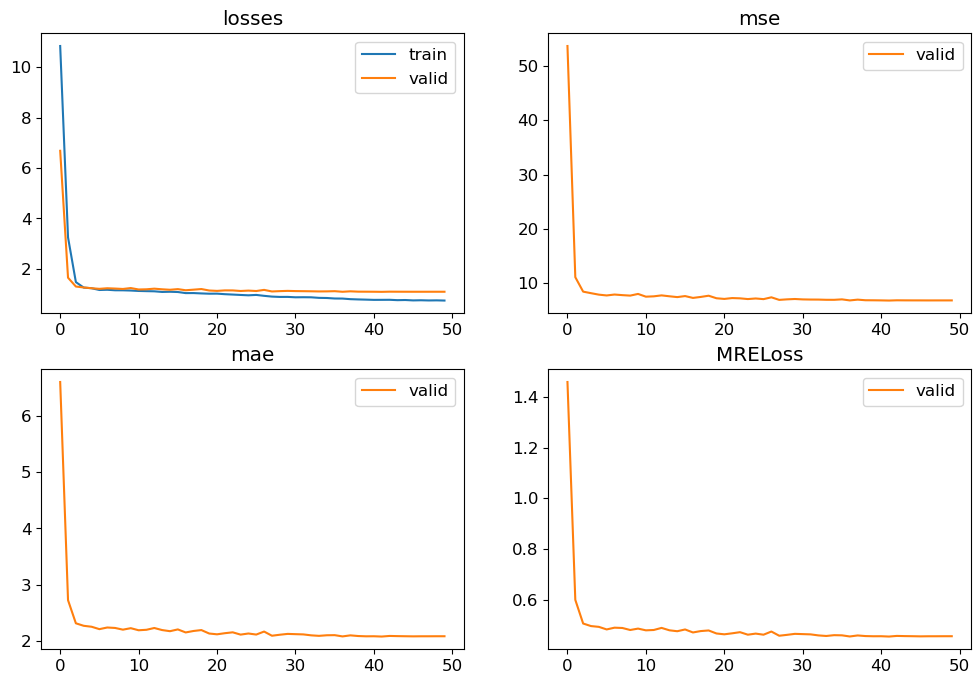

max bits is:  8
num bits used is:  9
loss is:  tensor(0.4538, device='cuda:0', grad_fn=<MeanBackward0>)


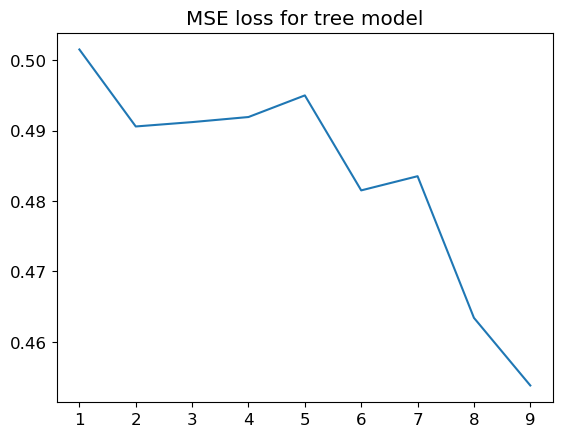

In [13]:
lodel = plot_bits_to_loss(10, loss_function, "tree", alpha, num_epochs, eval_loss, "MSE", train_pct, lg_N=5)


using 1 bits
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 1)
max node is (492, 492) gotten by max label: 15 * embedding matrix size:  494
[0, 3.147911787033081, 2.1891651153564453, 13.251510620117188, 3.2267446517944336, 0.960015594959259, '00:03']
[1, 1.5269930362701416, 1.5554710626602173, 9.716326713562012, 2.2100419998168945, 0.6487089991569519, '00:04']
[2, 1.5016422271728516, 1.5589991807937622, 9.695585250854492, 2.229820728302002, 0.6549340486526489, '00:03']
[3, 1.5287708044052124, 1.5641510486602783, 9.763859748840332, 2.22480845451355, 0.6530718803405762, '00:04']
[4, 1.5477005243301392, 1.557723045349121, 9.688806533813477, 2.2272887229919434, 0.6542693972587585, '00:04']
[5, 1.499665379524231, 1.5549920797348022, 9.725850105285645, 2.204484224319458, 0.6471182703971863, '00:03']
[6, 1.5203957557678223, 1.5570335388183594, 9.77095890045166, 2.1961190700531006, 0.6443749666213989, '00:02']
[7, 1.5144288539886475, 1.5631940364837646, 9.63870620727539, 2.

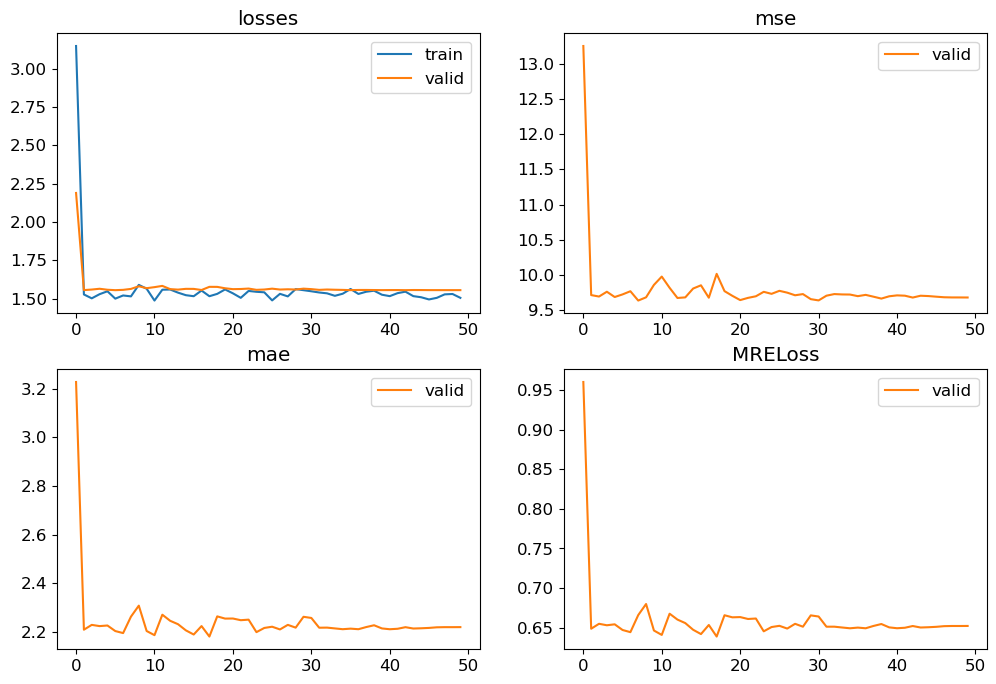

max bits is:  8
num bits used is:  1
loss is:  tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
using 2 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 2)
max node is (492, 492) gotten by max label: 15 * embedding matrix size:  494
[0, 2.140831708908081, 1.7206356525421143, 10.359745979309082, 2.572523593902588, 0.760734498500824, '00:04']
[1, 1.5011411905288696, 1.506300687789917, 9.282115936279297, 2.18414044380188, 0.6423215866088867, '00:04']
[2, 1.5284254550933838, 1.498953104019165, 9.31776237487793, 2.1458446979522705, 0.6301965713500977, '00:04']
[3, 1.534074068069458, 1.5018434524536133, 9.355834007263184, 2.1427292823791504, 0.6291772723197937, '00:03']
[4, 1.528568148612976, 1.4988017082214355, 9.196614265441895, 2.1881871223449707, 0.6434894800186157, '00:04']
[5, 1.5240001678466797, 1.5000371932983398, 9.25037956237793, 2.173068046569824, 0.6388878226280212, '00:03']
[6, 1.5319745540618896, 1.5118

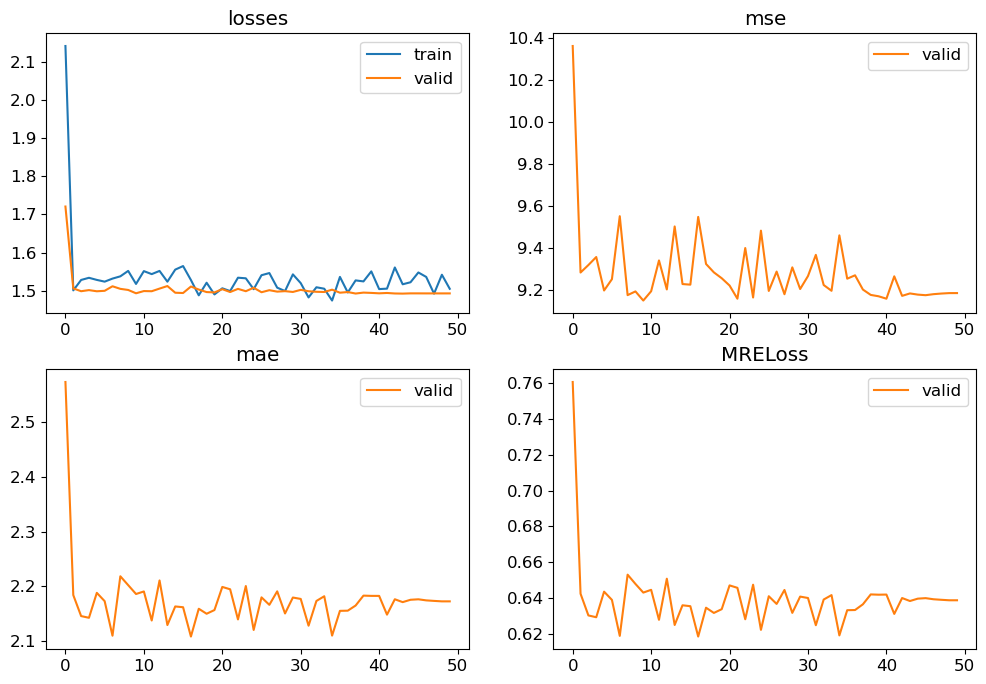

max bits is:  8
num bits used is:  2
loss is:  tensor(0.6363, device='cuda:0', grad_fn=<MeanBackward0>)
using 3 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 3)
max node is (492, 492) gotten by max label: 15 * embedding matrix size:  494
[0, 1.8610295057296753, 1.6197689771652222, 9.961037635803223, 2.388990640640259, 0.6929610371589661, '00:04']
[1, 1.5539324283599854, 1.535644769668579, 9.613494873046875, 2.2063639163970947, 0.6381053924560547, '00:04']
[2, 1.5426287651062012, 1.515329360961914, 9.400230407714844, 2.209017276763916, 0.6392291784286499, '00:03']
[3, 1.5023547410964966, 1.5119516849517822, 9.309268951416016, 2.230147123336792, 0.6455826759338379, '00:03']
[4, 1.4733679294586182, 1.508026361465454, 9.289593696594238, 2.222266912460327, 0.6434072852134705, '00:03']
[5, 1.468679428100586, 1.501093864440918, 9.507059097290039, 2.117361545562744, 0.611542820930481, '00:04']
[6, 1.460891604423523, 1.53003

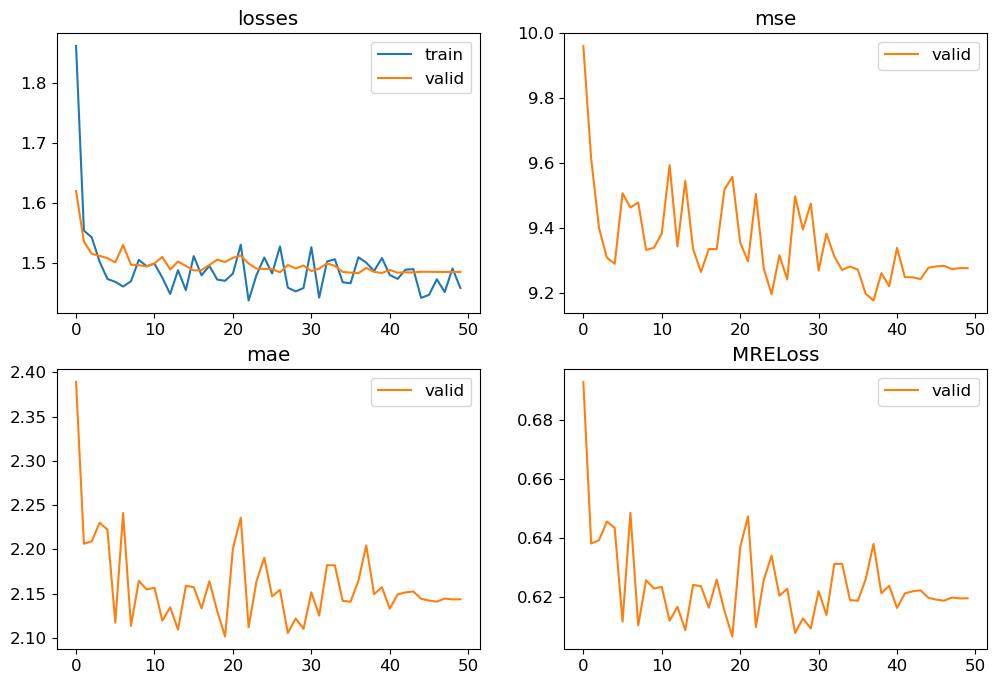

max bits is:  8
num bits used is:  3
loss is:  tensor(0.6197, device='cuda:0', grad_fn=<MeanBackward0>)
using 4 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 4)
max node is (492, 492) gotten by max label: 15 * embedding matrix size:  494
[0, 2.440415620803833, 1.8511370420455933, 11.239346504211426, 2.7596187591552734, 0.8080022931098938, '00:04']
[1, 1.5711759328842163, 1.5002657175064087, 9.281243324279785, 2.1835756301879883, 0.6357126235961914, '00:03']
[2, 1.504464864730835, 1.479796051979065, 9.193597793579102, 2.140367269515991, 0.6227073669433594, '00:04']
[3, 1.5360342264175415, 1.4665963649749756, 9.008304595947266, 2.159389019012451, 0.6286287903785706, '00:03']
[4, 1.4711837768554688, 1.4618953466415405, 9.01978874206543, 2.1381444931030273, 0.6221293210983276, '00:03']
[5, 1.4601174592971802, 1.454290747642517, 8.871110916137695, 2.164569854736328, 0.6301994919776917, '00:04']
[6, 1.4504132270812988, 1.

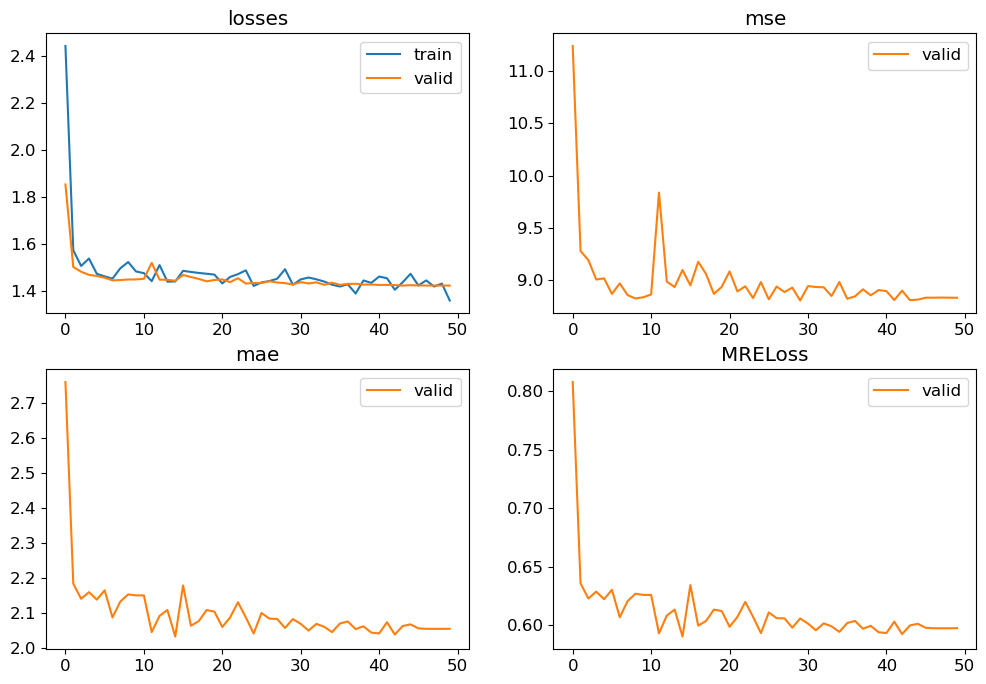

max bits is:  8
num bits used is:  4
loss is:  tensor(0.5967, device='cuda:0', grad_fn=<MeanBackward0>)
using 5 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 5)
max node is (492, 492) gotten by max label: 15 * embedding matrix size:  494
[0, 2.93939208984375, 2.1171882152557373, 12.921969413757324, 3.0938339233398438, 0.9166580438613892, '00:04']
[1, 1.5875555276870728, 1.5217702388763428, 9.41588020324707, 2.193694829940796, 0.6446467041969299, '00:04']
[2, 1.5173245668411255, 1.4858081340789795, 9.167936325073242, 2.151885986328125, 0.6322383880615234, '00:03']
[3, 1.4672292470932007, 1.4735496044158936, 9.13443660736084, 2.1197574138641357, 0.622340202331543, '00:03']
[4, 1.504502296447754, 1.4581304788589478, 8.903648376464844, 2.1462748050689697, 0.6308503746986389, '00:03']
[5, 1.4344401359558105, 1.4478236436843872, 8.873255729675293, 2.12056827545166, 0.6227752566337585, '00:04']
[6, 1.4409081935882568, 1.43

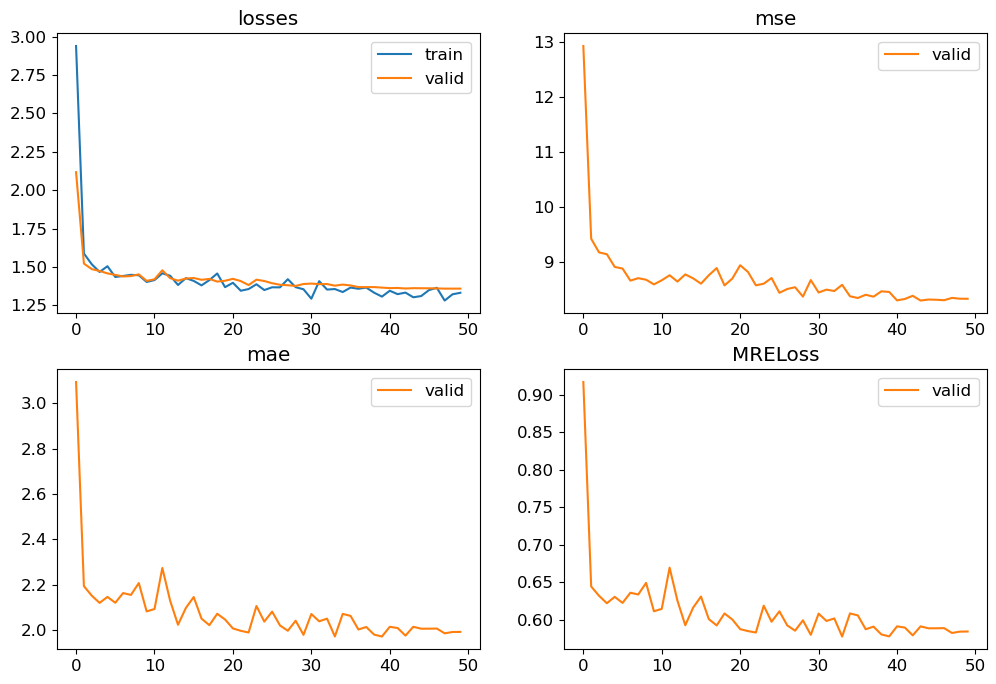

max bits is:  8
num bits used is:  5
loss is:  tensor(0.5839, device='cuda:0', grad_fn=<MeanBackward0>)
using 6 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 6)
max node is (492, 492) gotten by max label: 15 * embedding matrix size:  494
[0, 2.4399232864379883, 1.850900411605835, 11.22253704071045, 2.7452330589294434, 0.8096075654029846, '00:03']
[1, 1.5662227869033813, 1.498193621635437, 9.270071983337402, 2.1638574600219727, 0.634651243686676, '00:03']
[2, 1.5243644714355469, 1.4753094911575317, 9.1318941116333, 2.1301746368408203, 0.6245781183242798, '00:02']
[3, 1.447287917137146, 1.4665443897247314, 9.147859573364258, 2.092463731765747, 0.6130651831626892, '00:03']
[4, 1.4945333003997803, 1.4584888219833374, 8.881279945373535, 2.159642219543457, 0.6337336301803589, '00:02']
[5, 1.4831249713897705, 1.4404655694961548, 8.757855415344238, 2.1383256912231445, 0.6274220943450928, '00:03']
[6, 1.4372985363006592, 1.4

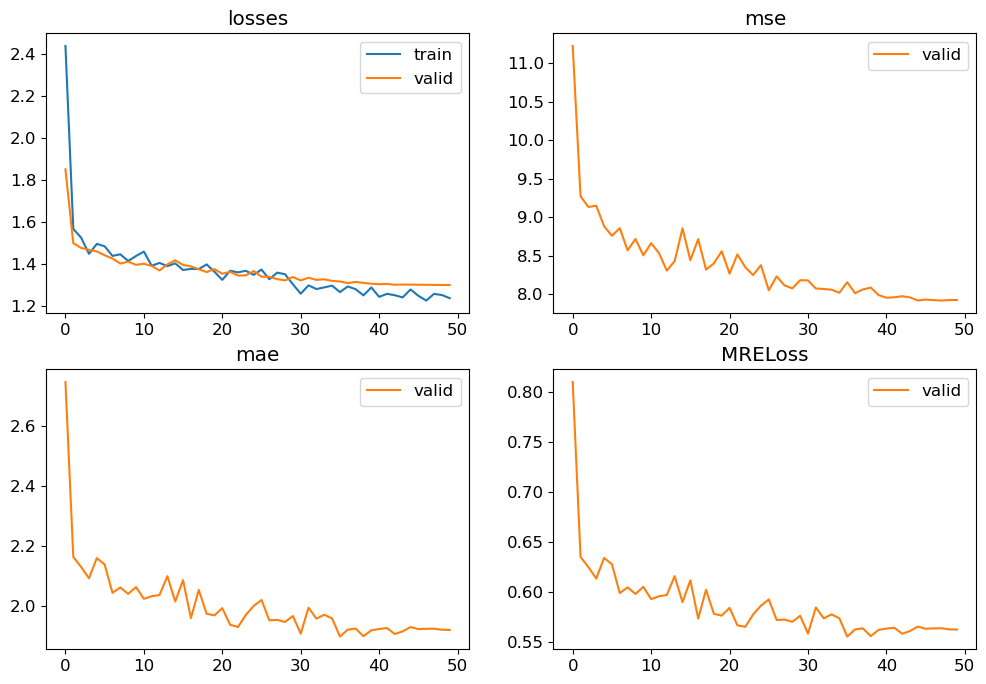

max bits is:  8
num bits used is:  6
loss is:  tensor(0.5620, device='cuda:0', grad_fn=<MeanBackward0>)
using 7 bits
similar data gotten before... retrieved data
recommended emb size [(494, 52), (494, 52)]
	using emb size: (494, 7)
max node is (492, 492) gotten by max label: 15 * embedding matrix size:  494
[0, 2.79435396194458, 1.9664486646652222, 11.863757133483887, 2.911243200302124, 0.8667473793029785, '00:02']
[1, 1.559926986694336, 1.4783976078033447, 9.031810760498047, 2.1611244678497314, 0.6391296982765198, '00:03']
[2, 1.5238794088363647, 1.443554401397705, 8.763861656188965, 2.1313517093658447, 0.6301867365837097, '00:03']
[3, 1.5101208686828613, 1.4216564893722534, 8.639937400817871, 2.097146987915039, 0.6196255087852478, '00:03']
[4, 1.479740858078003, 1.4143038988113403, 8.528756141662598, 2.1105520725250244, 0.6238088011741638, '00:03']
[5, 1.464979648590088, 1.4068658351898193, 8.390022277832031, 2.133277416229248, 0.6309594511985779, '00:02']
[6, 1.4336154460906982, 1.4

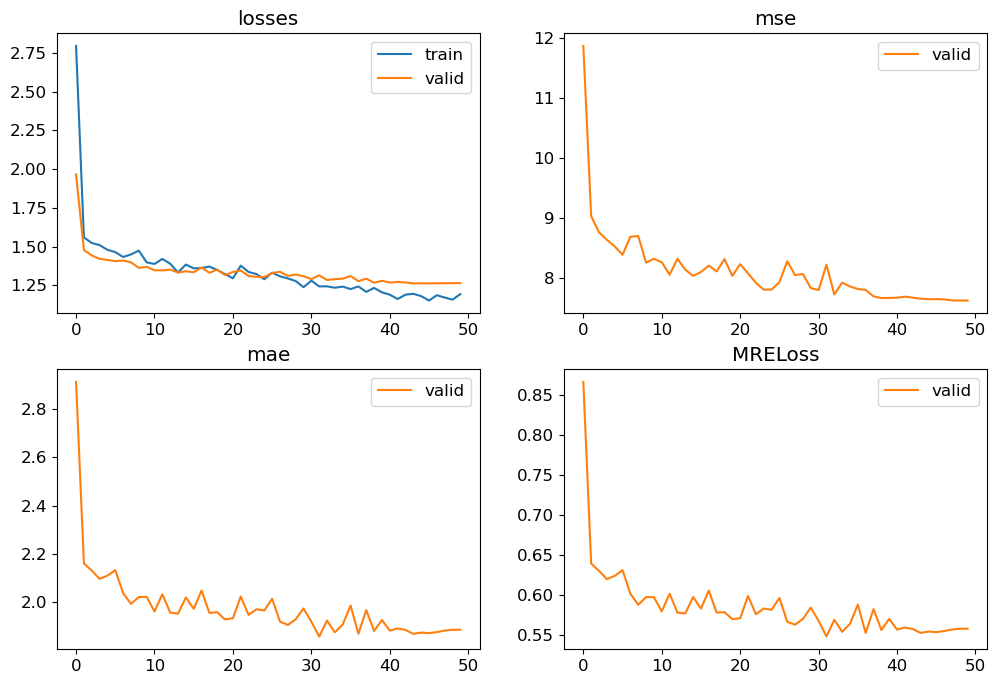

max bits is:  8
num bits used is:  7
loss is:  tensor(0.5561, device='cuda:0', grad_fn=<MeanBackward0>)


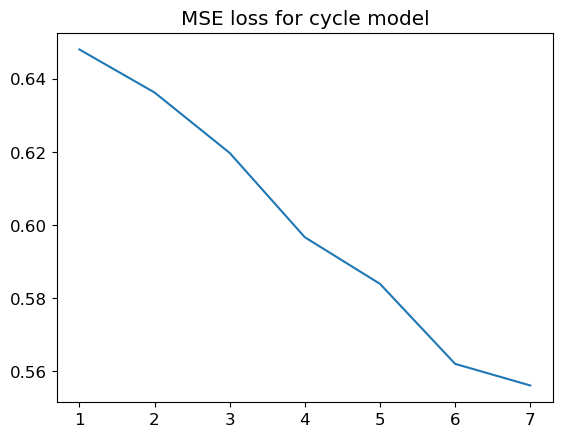

In [14]:
plot_bits_to_loss(8, loss_function, "cycle", alpha, num_epochs, eval_loss, "MSE", train_pct, lg_N=5)


using 1 bits
recommended emb size [(170, 28), (170, 28)]
	using emb size: (170, 1)
max node is (169, 169) gotten by max label: 18 * embedding matrix size:  170
[0, 5.559699535369873, 3.0033159255981445, 24.59784698486328, 4.110837936401367, 0.6039242744445801, '00:01']
[1, 2.053270101547241, 1.6775336265563965, 12.83487319946289, 2.9987733364105225, 0.43782928586006165, '00:01']
[2, 1.759748101234436, 1.6795679330825806, 12.852860450744629, 3.0020737648010254, 0.43809130787849426, '00:01']
[3, 1.7564674615859985, 1.685186505317688, 12.899758338928223, 3.0098512172698975, 0.4391230046749115, '00:01']
[4, 1.7359346151351929, 1.6807703971862793, 12.870894432067871, 2.9957053661346436, 0.4374236464500427, '00:01']
[5, 1.7515813112258911, 1.6847727298736572, 12.898150444030762, 3.008237600326538, 0.438841849565506, '00:02']
[6, 1.721318244934082, 1.6900166273117065, 12.948291778564453, 3.0087392330169678, 0.43909725546836853, '00:01']
[7, 1.7376735210418701, 1.6829382181167603, 12.882201194

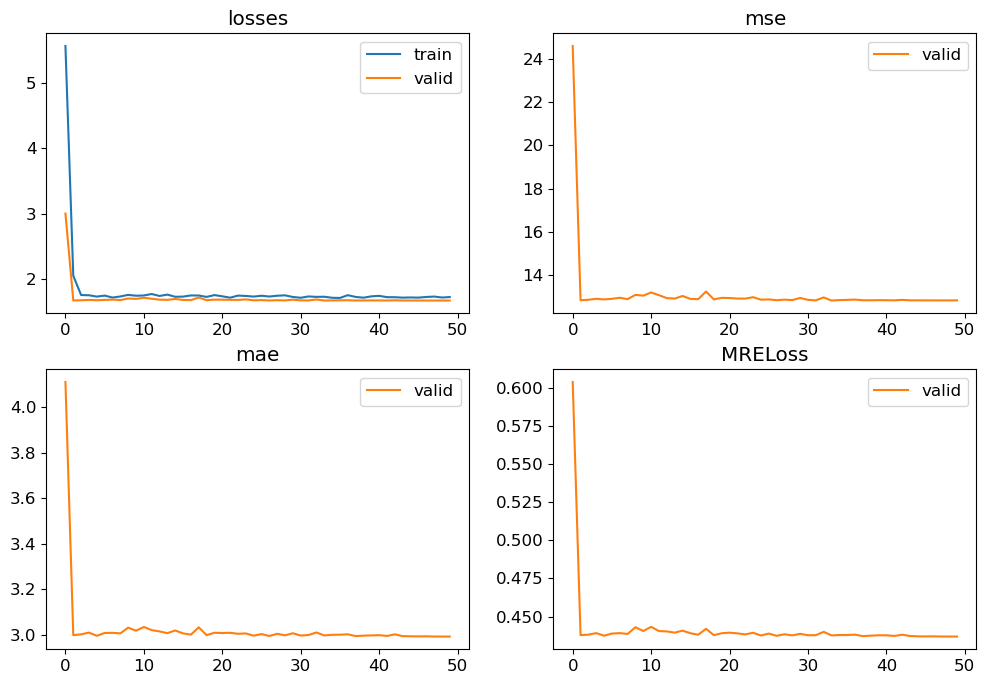

max bits is:  14
num bits used is:  1
loss is:  tensor(0.4344, device='cuda:0', grad_fn=<MeanBackward0>)
using 2 bits
similar data gotten before... retrieved data
recommended emb size [(170, 28), (170, 28)]
	using emb size: (170, 2)
max node is (169, 169) gotten by max label: 18 * embedding matrix size:  170
[0, 7.717206954956055, 4.4893317222595215, 38.01865768432617, 5.213683605194092, 0.763850748538971, '00:01']
[1, 2.405390977859497, 1.7221733331680298, 13.23763656616211, 3.0327484607696533, 0.4426773190498352, '00:01']
[2, 1.7913659811019897, 1.6860994100570679, 12.923564910888672, 3.0014259815216064, 0.4374917447566986, '00:01']
[3, 1.7301044464111328, 1.6792538166046143, 12.860845565795898, 2.996142625808716, 0.43685445189476013, '00:01']
[4, 1.741369366645813, 1.6835252046585083, 12.895983695983887, 3.00152325630188, 0.4376963973045349, '00:02']
[5, 1.7602006196975708, 1.7161582708358765, 13.189470291137695, 3.024353504180908, 0.4413459897041321, '00:01']
[6, 1.7367115020751953

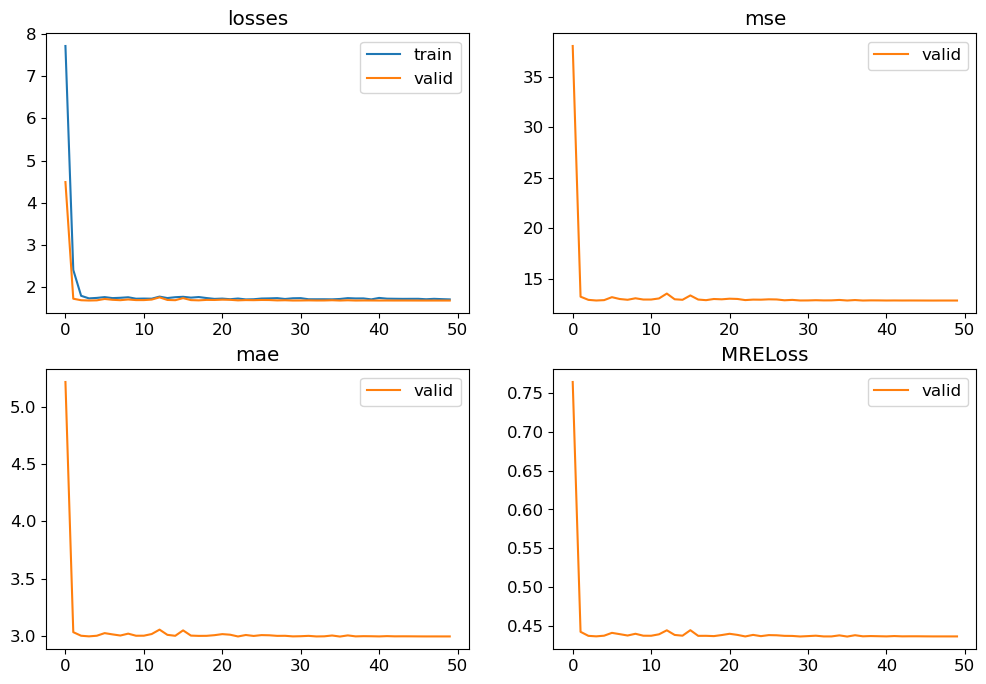

max bits is:  14
num bits used is:  2
loss is:  tensor(0.4350, device='cuda:0', grad_fn=<MeanBackward0>)
using 3 bits
similar data gotten before... retrieved data
recommended emb size [(170, 28), (170, 28)]
	using emb size: (170, 3)
max node is (169, 169) gotten by max label: 18 * embedding matrix size:  170
[0, 4.551370620727539, 2.71945858001709, 22.08637809753418, 3.8705649375915527, 0.5675784349441528, '00:01']
[1, 2.0347650051116943, 1.7790279388427734, 13.71887493133545, 3.096595048904419, 0.4523785412311554, '00:01']
[2, 1.7331844568252563, 1.7250580787658691, 13.240732192993164, 3.0497887134552, 0.4455387592315674, '00:01']
[3, 1.7155848741531372, 1.6997555494308472, 13.004944801330566, 3.0345258712768555, 0.4436233937740326, '00:02']
[4, 1.6991561651229858, 1.7010037899017334, 13.016695022583008, 3.036092519760132, 0.44370490312576294, '00:01']
[5, 1.7026593685150146, 1.7056310176849365, 13.055159568786621, 3.0423214435577393, 0.44457244873046875, '00:01']
[6, 1.67362701892852

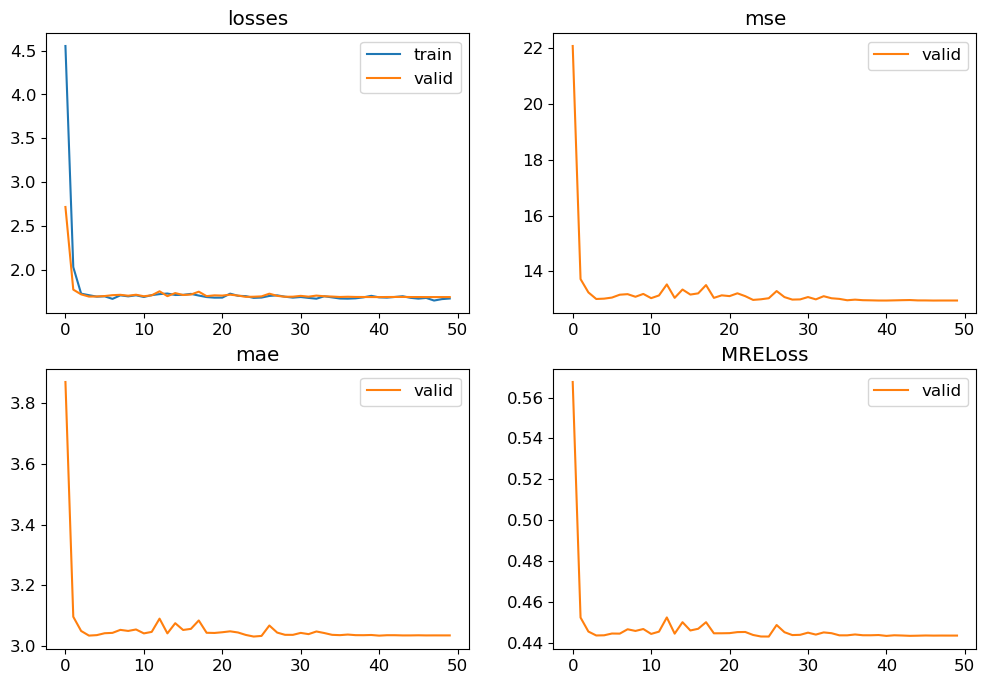

max bits is:  14
num bits used is:  3
loss is:  tensor(0.4410, device='cuda:0', grad_fn=<MeanBackward0>)
using 4 bits
similar data gotten before... retrieved data
recommended emb size [(170, 28), (170, 28)]
	using emb size: (170, 4)
max node is (169, 169) gotten by max label: 18 * embedding matrix size:  170
[0, 5.74432373046875, 3.2765259742736816, 27.09565544128418, 4.295027732849121, 0.6299559473991394, '00:01']
[1, 2.1731579303741455, 1.7650222778320312, 13.606581687927246, 3.0825600624084473, 0.44929373264312744, '00:01']
[2, 1.7806143760681152, 1.7016156911849976, 13.055052757263184, 3.020261764526367, 0.440123051404953, '00:02']
[3, 1.7014676332473755, 1.6671234369277954, 12.746891975402832, 2.991097927093506, 0.43603765964508057, '00:01']
[4, 1.6921160221099854, 1.665600299835205, 12.735301971435547, 2.985147714614868, 0.43563348054885864, '00:01']
[5, 1.6865590810775757, 1.670448660850525, 12.781776428222656, 2.988985061645508, 0.43585658073425293, '00:02']
[6, 1.6594793796539

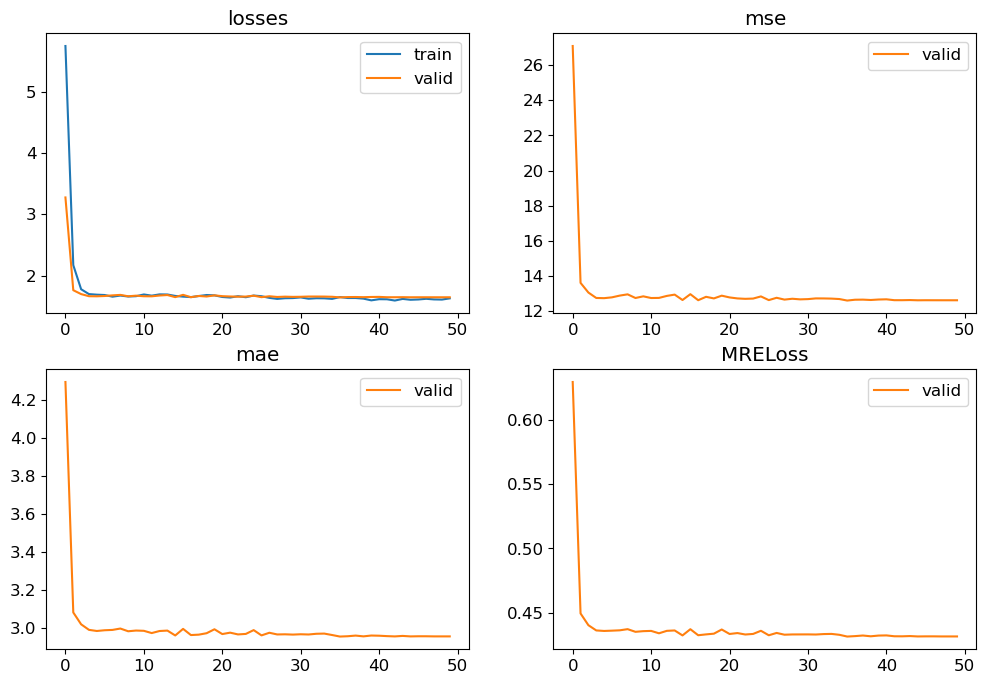

max bits is:  14
num bits used is:  4
loss is:  tensor(0.4296, device='cuda:0', grad_fn=<MeanBackward0>)
using 5 bits
similar data gotten before... retrieved data
recommended emb size [(170, 28), (170, 28)]
	using emb size: (170, 5)
max node is (169, 169) gotten by max label: 18 * embedding matrix size:  170
[0, 5.372983932495117, 3.1809451580047607, 26.2435245513916, 4.2385759353637695, 0.6184365749359131, '00:01']
[1, 2.1547393798828125, 1.756859302520752, 13.549882888793945, 3.075378894805908, 0.44652336835861206, '00:01']
[2, 1.7435903549194336, 1.6799547672271729, 12.87197208404541, 3.006033182144165, 0.4363970458507538, '00:01']
[3, 1.6830869913101196, 1.6432373523712158, 12.55470085144043, 2.9681830406188965, 0.430852472782135, '00:01']
[4, 1.659531593322754, 1.6439473628997803, 12.552193641662598, 2.9745395183563232, 0.4319198429584503, '00:02']
[5, 1.6278483867645264, 1.6448159217834473, 12.569985389709473, 2.970158338546753, 0.4309079647064209, '00:01']
[6, 1.64335036277771, 

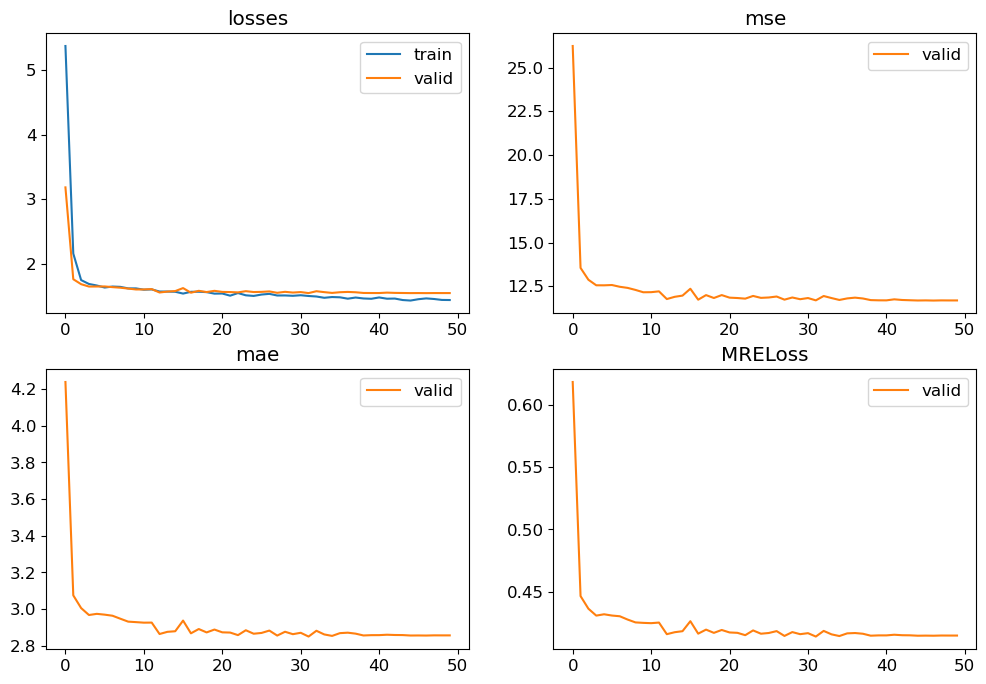

max bits is:  14
num bits used is:  5
loss is:  tensor(0.4136, device='cuda:0', grad_fn=<MeanBackward0>)
using 6 bits
similar data gotten before... retrieved data
recommended emb size [(170, 28), (170, 28)]
	using emb size: (170, 6)
max node is (169, 169) gotten by max label: 18 * embedding matrix size:  170
[0, 4.275056838989258, 2.6612699031829834, 21.644495010375977, 3.79492449760437, 0.5520226359367371, '00:02']
[1, 2.00424861907959, 1.813673496246338, 14.044111251831055, 3.1394882202148438, 0.4547361731529236, '00:01']
[2, 1.7301146984100342, 1.773398518562317, 13.688135147094727, 3.103795051574707, 0.4495388865470886, '00:01']
[3, 1.6698912382125854, 1.745103359222412, 13.434297561645508, 3.0802319049835205, 0.4463038146495819, '00:01']
[4, 1.6651538610458374, 1.7572883367538452, 13.552538871765137, 3.0874791145324707, 0.4467049241065979, '00:02']
[5, 1.654825210571289, 1.7306081056594849, 13.311997413635254, 3.0628576278686523, 0.44378700852394104, '00:01']
[6, 1.651856422424316

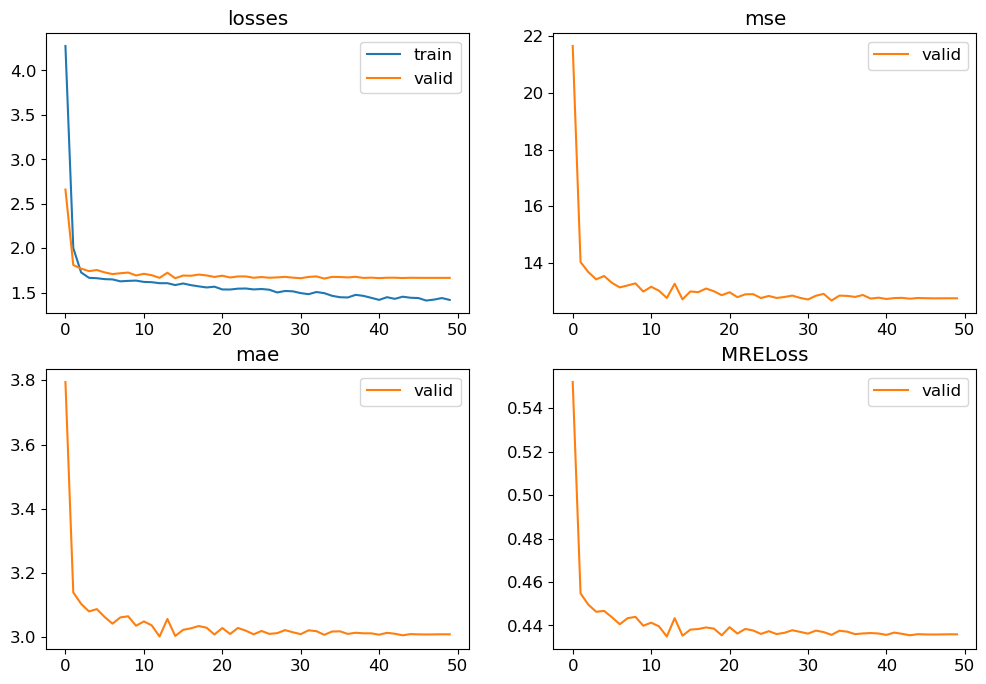

max bits is:  14
num bits used is:  6
loss is:  tensor(0.4342, device='cuda:0', grad_fn=<MeanBackward0>)
using 7 bits
similar data gotten before... retrieved data
recommended emb size [(170, 28), (170, 28)]
	using emb size: (170, 7)
max node is (169, 169) gotten by max label: 18 * embedding matrix size:  170
[0, 4.774665355682373, 2.826859712600708, 23.04486083984375, 3.9631593227386475, 0.5804152488708496, '00:01']
[1, 2.029879331588745, 1.7180213928222656, 13.220351219177246, 3.014071464538574, 0.43998512625694275, '00:01']
[2, 1.7030972242355347, 1.6696401834487915, 12.800467491149902, 2.966742992401123, 0.4328812062740326, '00:02']
[3, 1.6938979625701904, 1.646714210510254, 12.60171890258789, 2.943894386291504, 0.42949172854423523, '00:01']
[4, 1.637206792831421, 1.6289185285568237, 12.429369926452637, 2.9375762939453125, 0.42886796593666077, '00:01']
[5, 1.621605634689331, 1.6283775568008423, 12.439482688903809, 2.9259426593780518, 0.42714357376098633, '00:01']
[6, 1.6492484807968

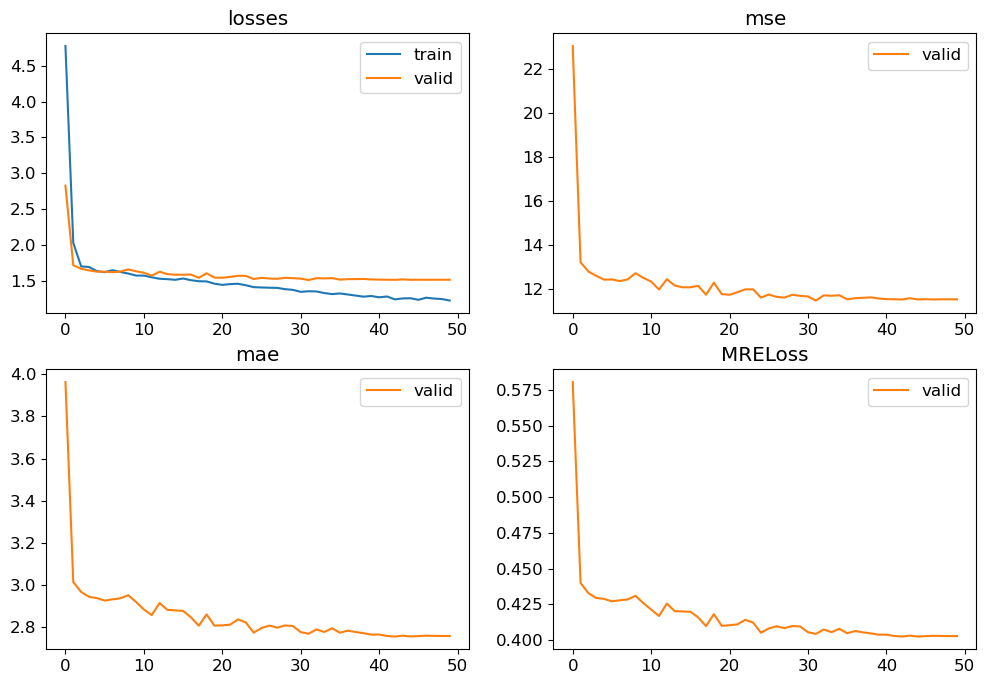

max bits is:  14
num bits used is:  7
loss is:  tensor(0.4011, device='cuda:0', grad_fn=<MeanBackward0>)


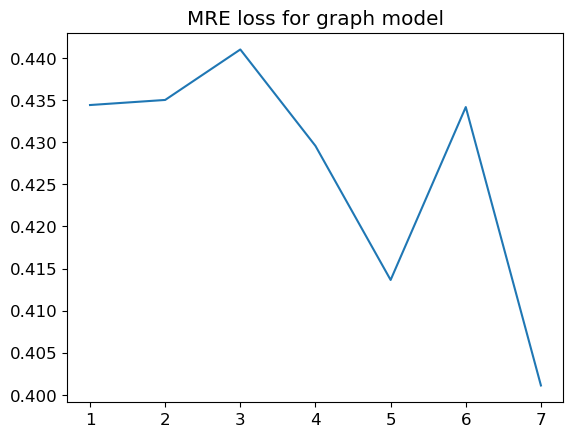

In [19]:
plot_bits_to_loss(8, loss_function, "graph", alpha, num_epochs, eval_loss, "MRE", train_pct)


In [15]:
lodel.dls.valid.dataset.items.iloc[:,:2]

AttributeError: 'NoneType' object has no attribute 'dls'

In [ ]:
type(lodel.dls.dataset)

In [ ]:
a = RandomSplitter()
x = a(range(10))
type(x[0])F

In [ ]:
torch.IntTensor(np.array(lodel.dls.valid.dataset.items.iloc[:,:2]))

In [ ]:
validset = torch.IntTensor(np.array(lodel.dls.valid.dataset.items.iloc[:,:2])).to(device)
y_targ = torch.IntTensor(np.array(lodel.dls.valid.dataset.items.iloc[:,2])).to(device)
preds = lodel.model(validset)
loss = eval_loss(preds, y_targ)
loss
